In [15]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio
import rasterio
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads
from shapely.ops import cascaded_union

import sys, os, time
import glob
import copy

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

# get boundaries

In [12]:
boundaries_path = "C:/Users/bramv/Downloads/gadm_410-gpkg/gadm_410.gpkg"

gadm_gdf = gpd.read_file(boundaries_path)
# gadm_gdf.dropna(subset=['TYPE_2', 'NAME_2'], inplace=True)


gadm_gdf = gadm_gdf[gadm_gdf['CONTINENT'] == 'Europe']

print(gadm_gdf.shape)

gadm_gdf.head()

(106252, 53)


,UID,GID_0,NAME_0,VARNAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,ISO_1,HASC_1,...,ENGTYPE_5,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION,COUNTRY,CONTINENT,SUBCONT,geometry
332,333,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.98333 60.64167, 20.98125 60..."
333,334,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.60028 59.81311, 20.60027 59..."
334,335,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.83333 60.03333, 20.83301 60..."
335,336,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.76042 60.46667, 20.75833 60..."
336,337,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.56875 60.18333, 20.56667 60..."


In [13]:
# athens = gadm_gdf[gadm_gdf['NAME_0'] == 'Finland']
# europe = gadm_gdf

# export gadm_gdf to csv
# gadm_gdf.to_csv('gadm_gdf.csv', index=False)
helsinki = gadm_gdf[gadm_gdf['NAME_3'] == 'Helsinki']
helsinki.head()

,UID,GID_0,NAME_0,VARNAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,ISO_1,HASC_1,...,ENGTYPE_5,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION,COUNTRY,CONTINENT,SUBCONT,geometry
55380,55381,FIN,Finland,,FIN.4_1,Southern Finland,Etelä-Suomen lääni|Södra Finland,,,FI.ES,...,,,Finland,,,,Finland,Europe,,"MULTIPOLYGON (((24.72031 60.06510, 24.71875 60..."
55381,55382,FIN,Finland,,FIN.4_1,Southern Finland,Etelä-Suomen lääni|Södra Finland,,,FI.ES,...,,,Finland,,,,Finland,Europe,,"MULTIPOLYGON (((25.04740 60.09635, 25.04583 60..."
55382,55383,FIN,Finland,,FIN.4_1,Southern Finland,Etelä-Suomen lääni|Södra Finland,,,FI.ES,...,,,Finland,,,,Finland,Europe,,"MULTIPOLYGON (((25.11142 60.66219, 25.11071 60..."
55383,55384,FIN,Finland,,FIN.4_1,Southern Finland,Etelä-Suomen lääni|Södra Finland,,,FI.ES,...,,,Finland,,,,Finland,Europe,,"MULTIPOLYGON (((25.16925 60.50683, 25.16853 60..."
55384,55385,FIN,Finland,,FIN.4_1,Southern Finland,Etelä-Suomen lääni|Södra Finland,,,FI.ES,...,,,Finland,,,,Finland,Europe,,"MULTIPOLYGON (((24.72503 60.22159, 24.72730 60..."


In [16]:
cities_gdf = helsinki[['NAME_0', 'GID_0', 'NAME_1', 'NAME_3', 'geometry']].copy()
cities_gdf.rename(columns={"NAME_1":"province", 
                           "GID_0":"countrycode",
                           "NAME_3":"city",
                           'NAME_0':"country"}, inplace=True)


# some cities/municipalities have the same name/province/country,
# we assume that they're part of the same region, and combine the boundary
# into a single polygon
cities_gdf = cities_gdf.groupby(['city', 'province', 'country', 'countrycode'])\
    .apply(lambda x: cascaded_union(x['geometry'].values) if len(x)>1 else x['geometry'].values[0]).reset_index()\
    .rename(columns={0:"geometry"})
cities_gdf = gpd.GeoDataFrame(cities_gdf) # the groupby operation casts to a Pandas DataFrame


C:\Users\bramv\AppData\Local\Temp\ipykernel_3812\2775358058.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  .apply(lambda x: cascaded_union(x['geometry'].values) if len(x)>1 else x['geometry'].values[0]).reset_index()\


In [17]:
import numpy as np
import geopandas as gpd
import pandas as pd
from pyproj import CRS, Transformer, Geod

# Assuming you have already imported the necessary libraries and have the GeoDataFrame 'cities_gdf'

# Define the WGS84 geodetic reference system
wgs84_crs = CRS("EPSG:4326")

def compute_geo_distance_km(latlon1, latlon2):
    lat1, lon1 = latlon1
    lat2, lon2 = latlon2

    az12, az21, dist = wgs84_geod.inv(lon1, lat1, lon2, lat2)

    return dist / 1.0e3  # return km

def compute_polygon_size(p):
    bbox = p.bounds

    try:
        L = compute_geo_distance_km((bbox[1], bbox[0]), (bbox[3], bbox[0]))
        W = compute_geo_distance_km((bbox[1], bbox[0]), (bbox[1], bbox[2]))
    except Exception as e:
        print("Error computing distances:", e)
        L, W = np.nan, np.nan

    # Compute the maximum of the calculated dimensions
    max_dimension = max([L, W])
    return max_dimension


# Set the CRS for the GeoDataFrame
original_crs = 'EPSG:4326'

transformer = Transformer.from_crs(original_crs, original_crs, always_xy=True)
wgs84_geod = Geod(ellps="WGS84")

cities_gdf.crs = original_crs

cities_gdf['scale'] = cities_gdf['geometry'].apply(compute_polygon_size)

# If you want to add individual columns for length and width
# cities_gdf[['length', 'width']] = pd.DataFrame(cities_gdf['scale'].tolist(), index=cities_gdf.index)

# If you also want to add the centroid as 'location' column
cities_gdf['location'] = cities_gdf['geometry'].centroid

# Calculate the area in the original CRS (EPSG:4326) and convert to square kilometers
cities_gdf['area'] = cities_gdf['geometry'].to_crs({'proj': 'cea'}).area / 1.0e6


# Display or use the updated GeoDataFrame
# print(cities_gdf[['city', 'province', 'country', 'area', 'scale', 'population', 'length', 'width', 'location']])


C:\Users\bramv\AppData\Local\Temp\ipykernel_3812\3566565666.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cities_gdf['location'] = cities_gdf['geometry'].centroid


In [18]:
# if area calculation fails, enter manually
cities_gdf['area'] = 213.8
cities_gdf

,city,province,country,countrycode,geometry,scale,location,area
0,Helsinki,Southern Finland,Finland,FIN,"MULTIPOLYGON (((24.36861 59.91097, 24.36861 59...",103.478203,POINT (24.85775 60.40339),213.8


In [30]:
path = "C:/Users/bramv/OneDrive - Square Four/Documenten/Leiden/23-24/urban computing/urbanization-patterns-master/urbanization-patterns-master/"

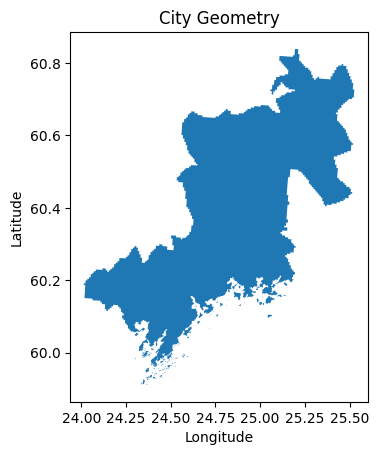

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.GeoDataFrame(cities_gdf, geometry='geometry')

# plot and save shapefile
gdf.plot()
plt.title("City Geometry")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

gdf['geometry'].to_file(path + "data/world-cities/Helsinki/Helsinki_bnd.shp")

In [32]:
# set paths
boundaries_path = path + 'data/world-cities/Helsinki/Helsinki_bnd.shp'
city_name = 'Helsinki'


#NL & landscan always the same
nightlights_path= path + 'data/nasa/big/VNL_v2_npp_2020_global_vcmslcfg_c202102150000.lit_mask.tif'
landscan_path= path + 'data/landscan-global-2022-assets/landscan-global-2022.tif'

# SAR
SAR_path = 'C:/Users/bramv/Downloads/Lay-out 1.tif'



# set up the tifs

In [33]:
import geopandas as gpd
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib import cm

def extract_and_save_data(city_name, boundaries_path, landscan_path, nightlights_path, SAR_path, output_dir):
    
    ams = gpd.read_file(boundaries_path)
    centroid = ams.geometry.centroid.iloc[0]

    cutout_width = 2  # 200km
    cutout_height = 2

    bbox = box(centroid.x - cutout_width/2, centroid.y - cutout_height/2, centroid.x + cutout_width/2, centroid.y + cutout_height/2)
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=ams.crs)

    landscan = rasterio.open(landscan_path)
    bbox_gdf = bbox_gdf.to_crs(landscan.crs)

    window_landscan = landscan.window(*bbox_gdf.total_bounds)
    out_image_landscan = landscan.read(1, window=window_landscan)
    
    plt.imshow(out_image_landscan, cmap='gist_heat')


    # save the cropped LandScan data as a GeoTIFF
    landscan_output_path = f'{output_dir}/POP_{city_name}.tif'
    with rasterio.open(landscan_output_path, 'w', driver='GTiff', count=1, dtype=out_image_landscan.dtype, crs=landscan.crs, transform=landscan.window_transform(window_landscan), width=window_landscan.width, height=window_landscan.height) as dst_landscan:
        dst_landscan.write(out_image_landscan, 1)

    nightlights = rasterio.open(nightlights_path)
    bbox_gdf = bbox_gdf.to_crs(nightlights.crs)

    window_nightlights = nightlights.window(*bbox_gdf.total_bounds)
    nightlights_data = nightlights.read(1, window=window_nightlights)

    # save the cropped nightlights data as a GeoTIFF
    nightlights_output_path = f'{output_dir}/NL_{city_name}.tif'
    with rasterio.open(nightlights_output_path, 'w', driver='GTiff', count=1, dtype=nightlights_data.dtype, crs=nightlights.crs, transform=nightlights.window_transform(window_nightlights), width=window_nightlights.width, height=window_nightlights.height) as dst_nightlights:
        dst_nightlights.write(nightlights_data, 1)

    SAR = rasterio.open(SAR_path)

    bbox_gdf = bbox_gdf.to_crs(SAR.crs)
    window_SAR = SAR.window(*bbox_gdf.total_bounds)

    SAR_data = SAR.read(1, window=window_SAR)

    # save the cropped SAR data as a GeoTIFF
    SAR_output_path = f'{output_dir}/SAR_{city_name}.tif'
    with rasterio.open(SAR_output_path, 'w', driver='GTiff', count=1, dtype=SAR_data.dtype, crs=SAR.crs, transform=SAR.window_transform(window_SAR), width=window_SAR.width, height=window_SAR.height) as dst_SAR:
        dst_SAR.write(SAR_data, 1)



C:\Users\bramv\AppData\Local\Temp\ipykernel_3812\3511570388.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = ams.geometry.centroid.iloc[0]


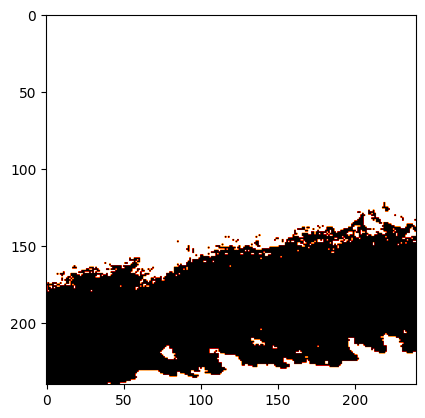

In [36]:
# set output directory and run function
output_dir = path + 'data/world-cities/' + city_name + '/'

extract_and_save_data(city_name, boundaries_path, landscan_path, nightlights_path, SAR_path, output_dir)


# shp to tif

In [37]:
# use nightlights as reference raster to convert boundaries to file to tif
from rasterio.features import geometry_mask

boundaries_path = path + 'data/world-cities/Helsinki/Helsinki_bnd.shp'
boundaries_gdf = gpd.read_file(boundaries_path)
reference_raster = path + 'data/world-cities/Helsinki/NLI_Helsinki.tif'

with rasterio.open(reference_raster) as ref_raster:
    width = ref_raster.width
    height = ref_raster.height
    transform = ref_raster.transform

mask = geometry_mask(boundaries_gdf.geometry, transform=transform, out_shape=(height, width), invert=True)
output_tif_path = path + 'data/world-cities/Helsinki/BND_Helsinki.tif'

with rasterio.open(output_tif_path, 'w', driver='GTiff', height=height, width=width, count=1, dtype='uint8', crs=ref_raster.crs, transform=transform) as dst:
    dst.write(mask.astype('uint8'), 1)